# Reliable Signal Propagation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import copy
import numpy as np
from scipy.signal import find_peaks
import scipy.fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import time
import torch
import pandas as pd

from src.network import Layer, PropagationNetwork, FullyConnectedLayerApprox, FullyConnectedLayerTorched, PropagationNetworkFCTorched
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment, MultiVariableExperiment
from src.lif import gaussian_kernel

sns.set()

(This notebook contains the code for _____ )

Transmit a *common* signal through biologically realistic feed-forward networks (BrFNN) is a non-trivial problem. In this notebook, and corresponding paper, we show how the synaptic weight representation for a network doing this task can be reduced from an $N*N$ matrix to an $N*1$ vector.

*./src* contains the core code for the BrFNNs, while this notebook contains our analysis of the behaviour of the reduced synaptic weight model and the full synaptic weight model

In [2]:
def default_style():
    sns.set(style="white")
    sns.set_context("talk", font_scale=2.0)
    plt.rc('axes',edgecolor='#FFFFFF')

def graph_psth(spikes, num_timesteps, save=None, color="#2598B2", title=None, xlabel=None, ylabel=None):
    graph_size = 5
    sns.set(style="white")
    sns.set_context("talk", font_scale=1.0)

    plt.figure(figsize=(graph_size*2, graph_size))
    plt.rc('axes',edgecolor='#FFFFFF')

    in_spike_inds, in_spike_trial = np.where(spikes[:num_timesteps] > 0)
    in_spike_inds = in_spike_inds * 1.0e-4 #float(num_timesteps)

    plt.scatter(in_spike_inds, in_spike_trial, s=6, marker='o', c=color)
    
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if save is not None:
        plt.savefig(save, bbox_inches="tight")
    else:
        plt.show()
    plt.close()
    
    default_style()

def graph_firing_rates(in_fr, out_fr, num_timesteps, save=None, in_color="#888888", out_color='#189B48'):
    sns.set(style="white")
#     sns.set_context("talk", font_scale=2.5)
    plt.rc('axes',edgecolor='#FFFFFF')

    t = np.arange(0, num_timesteps / 1.0e-4, 1e-4)

    plt.figure(figsize=(5,4))
    plt.ylim(top=60)

    plt.plot(t, in_fr.mean(1).numpy()[:num_timesteps], c=in_color, lw=5.0)
    plt.plot(t, out_fr.mean(1).numpy()[:num_timesteps], c=out_color, lw=5.0)

    sns.despine()
    
    if save is not None:
        plt.savefig(save, bbox_inches="tight")
    else:
        plt.show()
    plt.close()
    
    default_style()

In [3]:
NUM_NEURONS = 200
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 3.0e3 # 30.0e3
test_t_stop = 5000.0

INP_OU_TAU = 50.0

RESULTS_DIR = "./results/ieee_rev"
GRAPHS_DIR = "./graphs"

default_style()

BLUE = '#3b668a'

We attempt to transmit a 

In [4]:
LOAD_TRAIN = True
load_train_file = "ieee-rev-train-3.0s.npy"

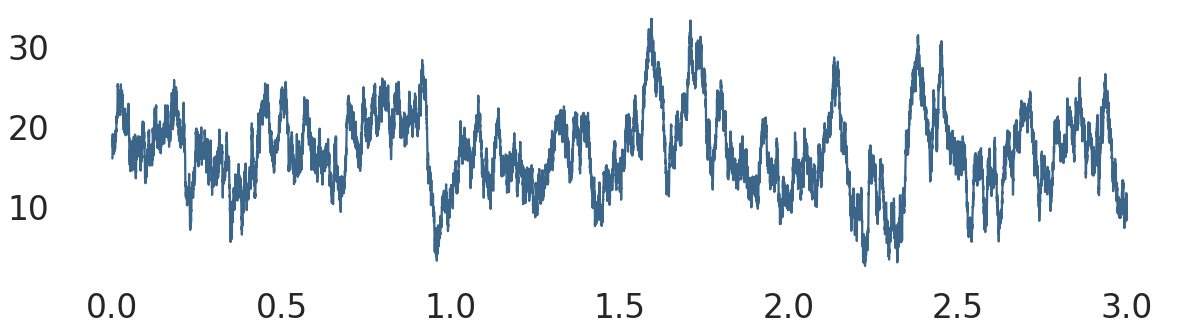

In [6]:
# INPUT: Slow Signal

t = np.arange(0, t_stop * 1.0e-3, 1.0e-4)

if LOAD_TRAIN:
    i_inj = np.load(os.path.join(RESULTS_DIR, load_train_file))
else:
    input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, t_stop, 1)
    i_inj = 16.0 + 6.0*input_slow
    
    np.save(os.path.join(RESULTS_DIR, load_train_file), i_inj)

plt.figure(figsize=(20,5))
plt.plot(t, i_inj, color=BLUE)
# plt.title("Train Input: OUProcess")
# plt.xlabel("t (sec)")
# plt.ylabel("Current (pA)")
# plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-training-inp.png")))

In [7]:
LOAD_TEST = True
load_test_file = "ieee-rev-test-5.0s.npy"

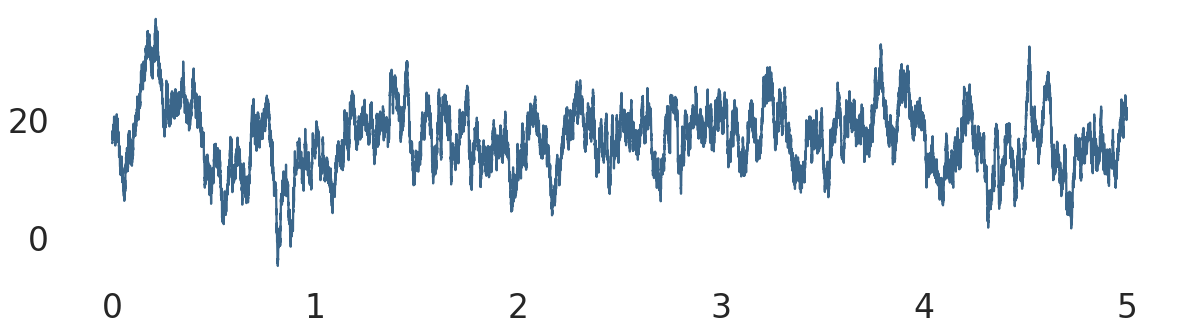

In [8]:
# INPUT: Slow Signal

test_t = np.arange(0, test_t_stop * 1.0e-3, 1.0e-4)

if LOAD_TEST:
    test_i_inj = np.load(os.path.join(RESULTS_DIR, load_test_file))
else:
    test_input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
    test_i_inj = 16.0 + 6.0*test_input_slow

    np.save(os.path.join(RESULTS_DIR, load_test_file), test_i_inj)

plt.figure(figsize=(20,5))
plt.plot(test_t, test_i_inj, color=BLUE)
# plt.title("Test Input: OUProcess")
# plt.xlabel("t (sec)")
# plt.ylabel("Current (pA)")
# plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-test-inp.png")))

# Reduced Synaptic Weight Model

In [9]:
LOAD_LAYER = True
load_ieee_reducednet_cf_file = "ieee_rednet_vs_fcn_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

if LOAD_LAYER:
    experiment = Experiment.load(RESULTS_DIR, load_ieee_reducednet_cf_file)
    layer = experiment.layer
else:
    layer = Layer(NUM_NEURONS)
    layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
#     layer.save()

In [20]:
out, V, F_binary, F_synaptic = layer.output(i_inj, dt, t_stop)
_, spike_out = layer.spike(out, dt, t_stop, int_noise_regen=True)

cf_train = 1.0 - np.linalg.norm(out-i_inj)/np.linalg.norm(i_inj)
print("Coding fraction: training data", cf_train)

Coding fraction: training data 0.7555005799042401


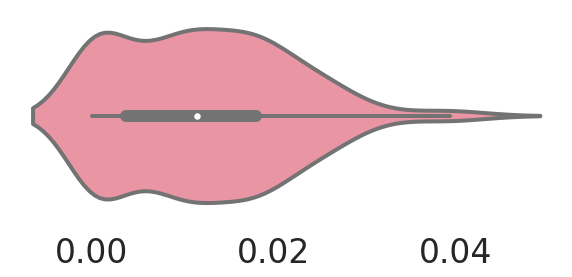

In [10]:
# Weight Distribution

plt.figure(figsize=(10,4))
sns.set_context("talk", font_scale=2.0)
sns.violinplot(layer.W, linewidth=4, color=sns.xkcd_rgb["rose pink"])
# plt.title("Synaptic Weight Distribution")
# plt.xlabel("Weight (pA/mV)")
# plt.savefig((os.path.join(GRAPHS_DIR, "rednet_weights.png")))
# plt.show()
# plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-rednet-weights.png")), bbox_inches='tight')

In [23]:
start_time = time.time()
out, V, F_binary, F_synaptic = layer.output(test_i_inj, dt, test_t_stop)
_, spike_out = layer.spike(out, dt, test_t_stop, int_noise_regen=True)
print(time.time() - start_time)

8.09885835647583


In [24]:
start_time = time.time()
in_fr = layer.firing_rate(F_binary, dt, test_t_stop)
out_fr = layer.firing_rate(spike_out, dt, test_t_stop)
print(time.time() - start_time)

103.87032651901245


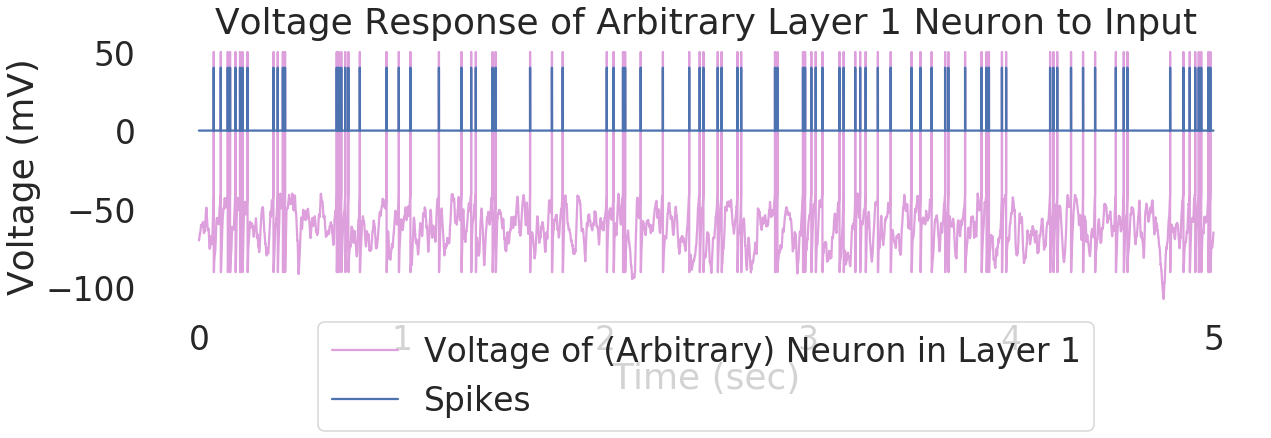

In [25]:
# Voltage + Spike graph
neuron_ind = 10
t_i = 0
t_f = len(test_t)

plt.figure(figsize=(20,5))
plt.plot(test_t, V[t_i:t_f, neuron_ind], color='plum', label="Voltage of (Arbitrary) Neuron in Layer 1")
plt.plot(test_t, F_binary[t_i:t_f, neuron_ind] * 40.0, label="Spikes")
plt.title("Voltage Response of Arbitrary Layer 1 Neuron to Input")
plt.xlabel("Time (sec)")
plt.ylabel("Voltage (mV)")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
# TODO: LEGEND
plt.show()

In [105]:
# graph_psth(F_binary, 10000, title="Input Firing", xlabel="Time (sec)", ylabel="Neuron Index", save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_input_spikes.png")))
graph_psth(F_binary, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_input_spikes.png")))

In [106]:
# graph_psth(spike_out, 10000, title="Output Firing", xlabel="Time (sec)", ylabel="Neuron Index"), save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_output_spikes.png"))
graph_psth(spike_out, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_output_spikes.png")))

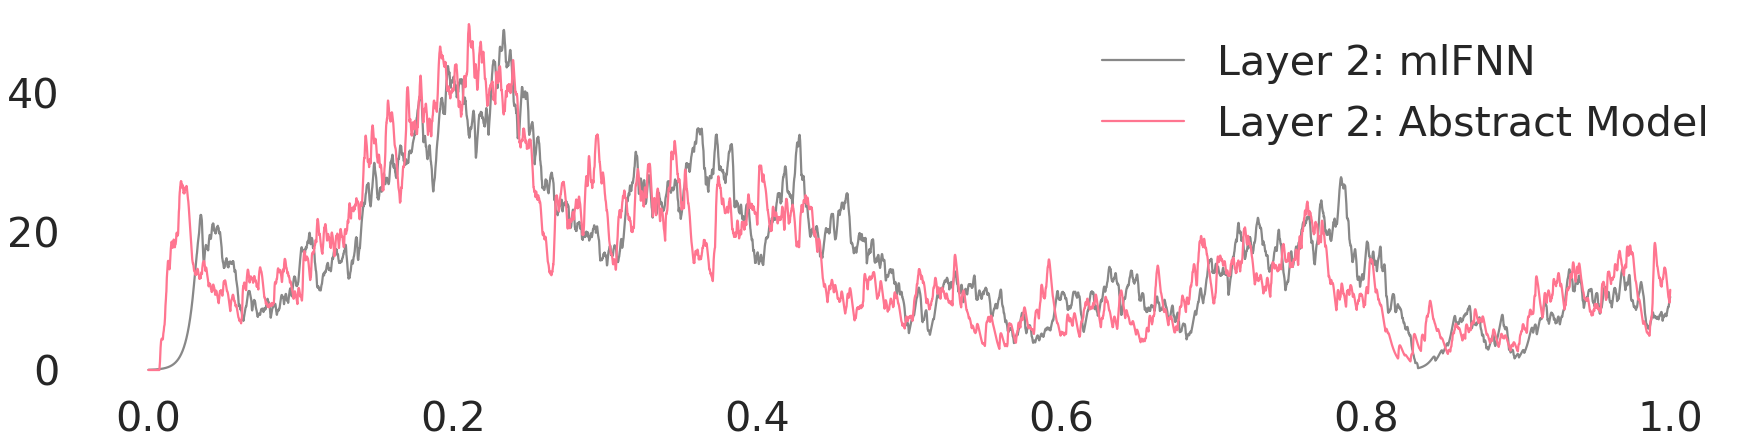

In [117]:
# plt.figure(figsize=(20,4))
plt.figure(figsize=(30,7))
sns.set_context("talk", font_scale=2.5)
plt.plot(test_t[:10000], fcl_out.mean(1).numpy()[:10000], "#888888", label="Layer 2: mlFNN")
plt.plot(test_t[:10000], out[:10000], '#FF7590', label="Layer 2: Abstract Model")
plt.legend(edgecolor="white")
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-fig4c-rednet-output.png")), bbox_inches='tight')

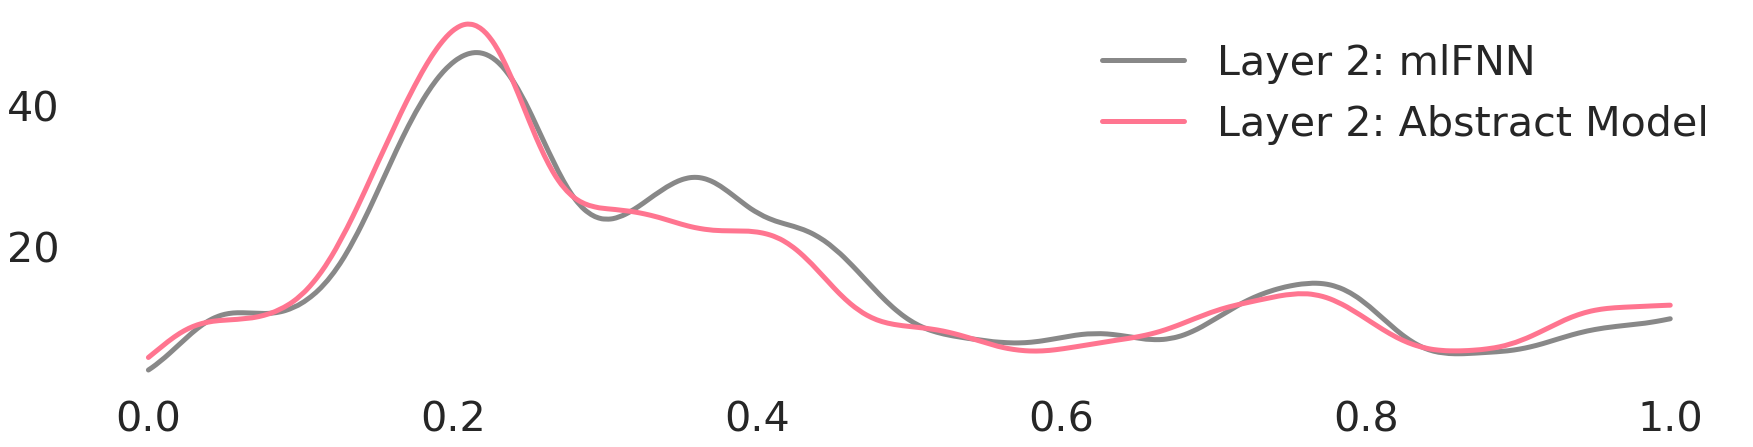

In [116]:
# sns.set(style="white")
# sns.set_context("talk", font_scale=1.5)
# plt.rc('axes',edgecolor='#666666')

# plt.figure(figsize=(20,4))
plt.figure(figsize=(30,7))
sns.set_context("talk", font_scale=2.5)
plt.plot(test_t[:10000], fcl_out_fr.mean(1).numpy()[:10000], "#888888", label="Layer 2: mlFNN", linewidth=5)
plt.plot(test_t[:10000], out_fr.mean(1).numpy()[:10000], '#FF7590', label="Layer 2: Abstract Model", linewidth=5)

# plt.title("Propagation of Signal (Reduced Network): Inst. Firing Rate")
# plt.xlabel("Time (s)")
# plt.ylabel("Inst. Firing Rate (Hz)")
plt.legend(edgecolor="white")

sns.despine()

# plt.show()
plt.savefig((os.path.join(GRAPHS_DIR, "iee-rev-fig4c-fr-redn_unc.png")), bbox_inches='tight')

In [75]:
LOAD_IEEE_REDUCEDNET_CF = True
load_ieee_reducednet_cf_file = "ieee_rednet_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

In [76]:
if LOAD_IEEE_REDUCEDNET_CF:
    experiment = Experiment.load(RESULTS_DIR, load_ieee_reducednet_cf_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    exp_inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        exp_input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
        exp_i_inj = 16.0 + 6.0*exp_input_slow
        exp_inputs[:,i] = exp_i_inj.flatten()

    experiment = Experiment(exp_inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_ieee_reducednet_cf_file)

In [77]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.sqrt(np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i]))/np.sqrt(np.linalg.norm(experiment.inputs[:, i]))

# np.savez(os.path.join(RESULTS_DIR, "iee-rev-rednet-cfs.npz"))

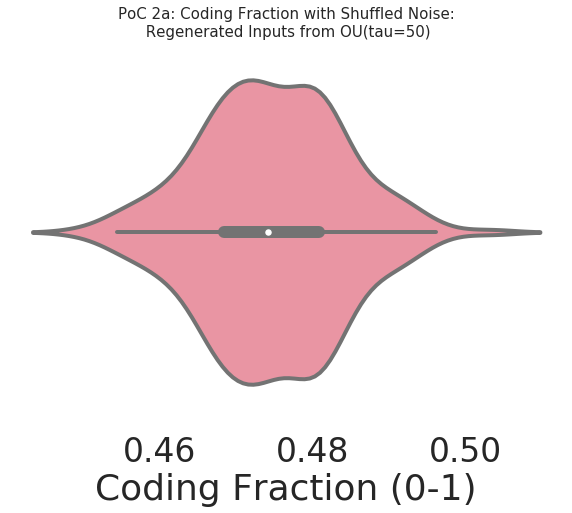

In [78]:
plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_ieee_reducednet_cf_file + ".png"))

# Full Synaptic Weight Model: Verification

In [30]:
LOAD_LAYER = True
load_layer_file = "fcl_neurons=200"

GPU_MODE = "gpu" # Change to "cpu" if you want to use CPU

if LOAD_LAYER:
    fcl = FullyConnectedLayerTorched.load(RESULTS_DIR, load_layer_file, device=GPU_MODE)
else:
    fcl = FullyConnectedLayerTorched(NUM_NEURONS, std_noise=25.0, device=GPU_MODE)
    fcl.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)
    fcl.save(RESULTS_DIR, load_layer_file)

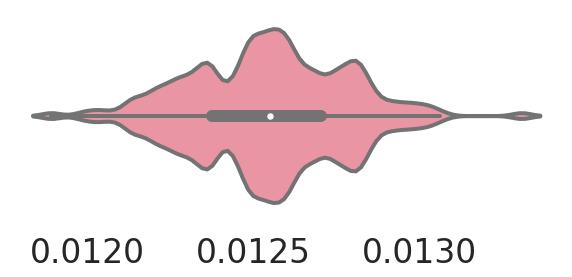

In [31]:
# Weight Distribution

plt.figure(figsize=(10,4))
sns.set_context("talk", font_scale=2.0)
sns.violinplot(fcl.W, linewidth=4, color=sns.xkcd_rgb["rose pink"])
# plt.title("Synaptic Weight Distribution")
# plt.xlabel("Weight (pA/mV)")
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-fcl_weights.png")), bbox_inches='tight')
# plt.show()

In [32]:
start_time = time.time()
fcl_out, fcl_V, fcl_F_binary, fcl_F_synaptic = fcl.output(test_i_inj, dt, test_t_stop)
_, fcl_spike_out = fcl.spike(fcl_out, dt, test_t_stop, int_noise_regen=True)
print(time.time() - start_time)

49.57905340194702


In [33]:
start_time = time.time()
fcl_in_fr = fcl.firing_rate(fcl_F_binary, dt, test_t_stop)
fcl_out_fr = fcl.firing_rate(fcl_spike_out, dt, test_t_stop)
print(time.time() - start_time)

104.45183181762695


In [34]:
fcl_tr_out, fcl_tr_V, fcl_tr_F_binary, fcl_tr_F_synaptic = fcl.output(fcl.train_input, dt, t_stop)
_, fcl_tr_spike_out = fcl.spike(fcl_tr_out, dt, t_stop, int_noise_regen=True)

In [38]:
# fcl_tr_cf = 1.0 - np.sqrt(np.linalg.norm(fcl_out.mean(1).numpy().flatten()-test_i_inj))/np.sqrt(np.linalg.norm(test_i_inj))
fcl_tr_cf = 1.0 - np.linalg.norm(fcl_tr_out.mean(1).numpy()-fcl.train_input)/np.linalg.norm(fcl.train_input)
print("Coding fraction: trainig data:", fcl_tr_cf)
# fcl_tr_cf

Coding fraction: trainig data: -113.88469729103791


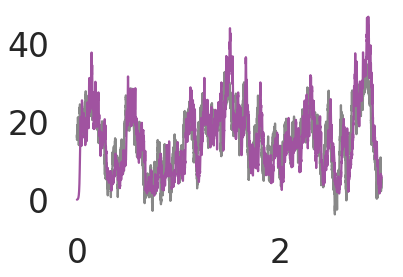

In [37]:
plt.plot(t, fcl.train_input, "#888888", label="Input")
plt.plot(t, fcl_tr_out.mean(1).numpy(), '#a053a0', label="Output: FCN-Grad")

In [110]:
# graph_psth(fcl_F_binary, 10000, title="Input Firing", xlabel="Time (sec)", ylabel="Neuron Index") # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_input_spikes.png")
graph_psth(fcl_F_binary, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee_rev_verif_fcl_approx_input_spikes.png")))

In [111]:
# graph_psth(fcl_spike_out, 10000, title="Output Firing", xlabel="Time (sec)", ylabel="Neuron Index") # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_output_spikes.png"))
graph_psth(fcl_spike_out, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee_rev_verif_fcl_approx_output_spikes.png")))

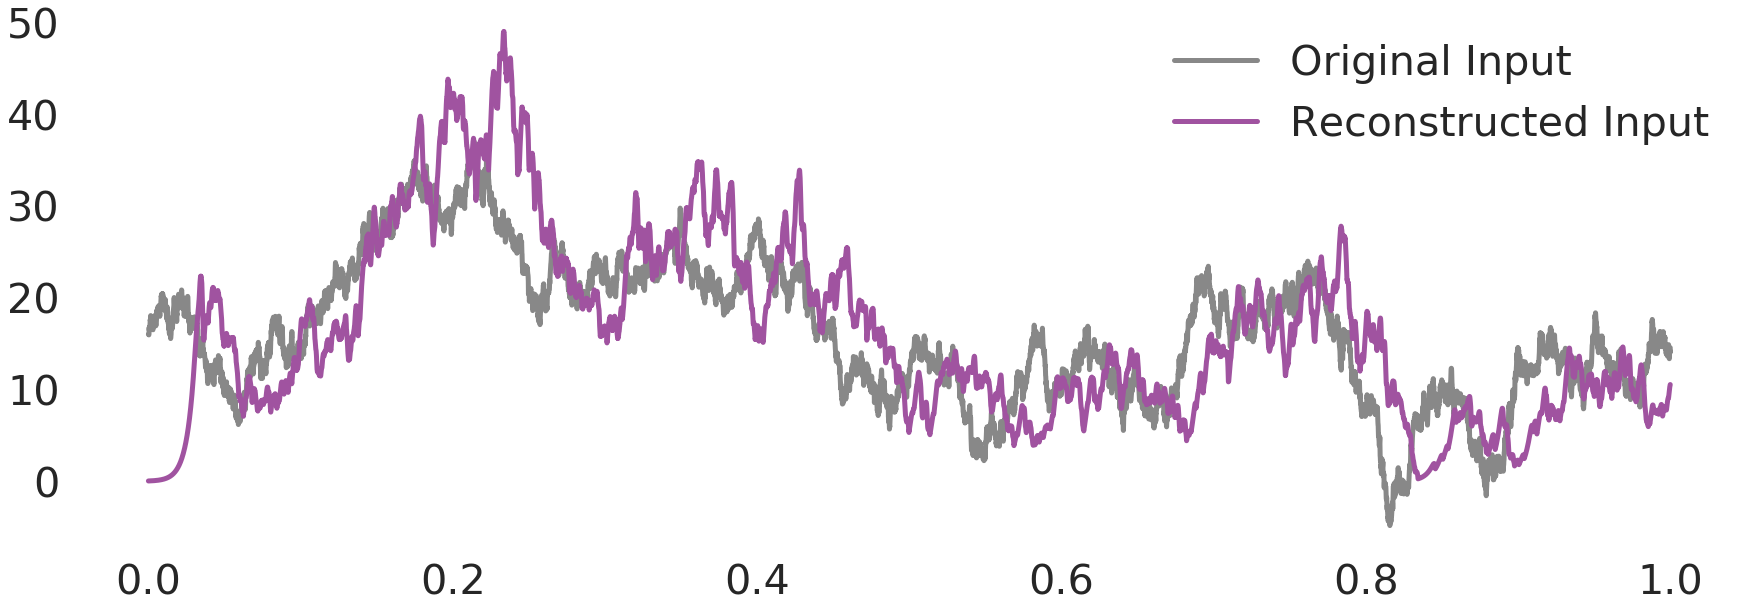

In [120]:
plt.figure(figsize=(30,10))
sns.set_context("talk", font_scale=2.5)
plt.plot(test_t[:10000], test_i_inj[:10000], "#888888", label="Original Input", linewidth=5)
plt.plot(test_t[:10000], fcl_out.mean(1).numpy()[:10000], '#a053a0', label="Reconstructed Input", linewidth=5)
plt.legend(edgecolor="white")
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-fig4c-fcn-output.png")), bbox_inches='tight')

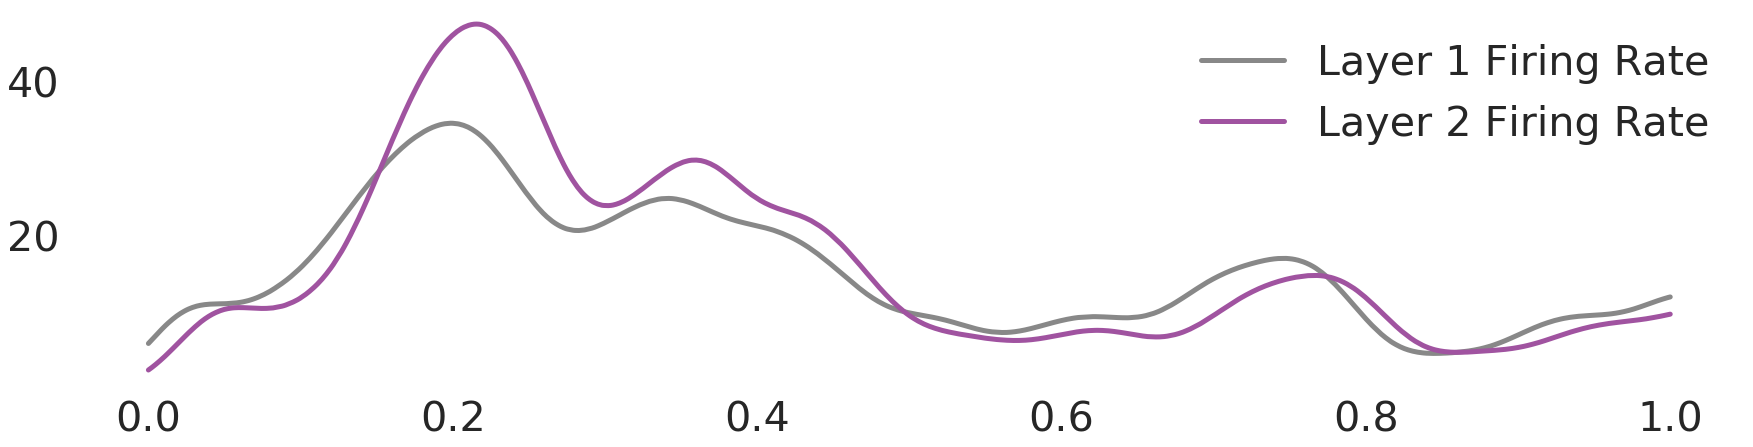

In [115]:
# sns.set(style="white")
# sns.set_context("talk", font_scale=1.5)
# plt.rc('axes',edgecolor='#666666')

# plt.figure(figsize=(20,4))
plt.figure(figsize=(30,7))
sns.set_context("talk", font_scale=2.5)
plt.plot(test_t[:10000], fcl_in_fr.mean(1).numpy()[:10000], "#888888", label="Layer 1 Firing Rate", linewidth=5)
plt.plot(test_t[:10000], fcl_out_fr.mean(1).numpy()[:10000], '#a053a0', label="Layer 2 Firing Rate", linewidth=5)

# plt.title("Propagation of Signal (Reduced Network): Inst. Firing Rate")
# plt.xlabel("Time (s)")
# plt.ylabel("Inst. Firing Rate (Hz)")

sns.despine()
plt.legend(edgecolor="white")

# plt.show()
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-fig4c-fr-fcn.png")), bbox_inches='tight')

In [39]:
LOAD_IEEE_FCL_CF = True
load_ieee_fcl_cf_file = "ieee_fcl_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

In [41]:
if LOAD_IEEE_FCL_CF:
    fcl_experiment = Experiment.load(RESULTS_DIR, load_ieee_fcl_cf_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    exp_inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        exp_input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
        exp_i_inj = 16.0 + 6.0*exp_input_slow
        exp_inputs[:,i] = exp_i_inj.flatten()

    fcl_experiment = Experiment(exp_inputs, fcl, NUM_TRIALS, dt, test_t_stop, num_neurons=NUM_NEURONS)
    spikes = fcl_experiment.run()
    fcl_experiment.save(RESULTS_DIR, load_ieee_fcl_cf_file)

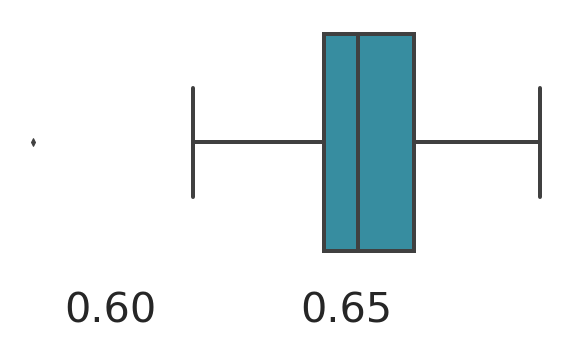

In [57]:
fcl_efficiencies = np.empty((fcl_experiment.num_trials))

for i in range(fcl_experiment.num_trials):
    fcl_efficiencies[i] = 1.0 - np.linalg.norm(np.average(fcl_experiment.outputs[:, i], axis=1)-fcl_experiment.inputs[:, i])/np.linalg.norm(fcl_experiment.inputs[:, i])

# plt.figure(figsize=(10,7))

# sns.violinplot(fcl_efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
# plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
# plt.xlabel('Coding Fraction (0-1)')

# plt.show()

plt.figure(figsize=(10,5))

sns.boxplot(fcl_efficiencies, orient='h', linewidth=4, color='#2598B2')
# plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
# plt.xlabel('Coding Fraction (0-1)')

# plt.show()
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-compare-coding-fractions.png")), bbox_inches='tight')
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc_2a_file + ".png"))

In [ ]:
del fcl_experiment

In [13]:
LOAD_IEEE_REDUCEDNET_VS_FCN_CF = True
load_ieee_reducednet_vs_fcn_cf_file = "ieee_rednet_vs_fcn_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

In [14]:
if LOAD_IEEE_REDUCEDNET_VS_FCN_CF:
    experiment = Experiment.load(RESULTS_DIR, load_ieee_reducednet_vs_fcn_cf_file)
else:
    NUM_TRIALS = 200

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    exp_inputs = np.empty((num_t, NUM_TRIALS))

    experiment = Experiment(fcl_experiment.inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_ieee_reducednet_vs_fcn_cf_file)

In [29]:
NUM_COMP_TRIALS = 50

exp_efficiencies = np.empty((NUM_COMP_TRIALS))

start_time = time.time()

for i in range(NUM_COMP_TRIALS):
    out, _, F_binary, _ = layer.output(experiment.inputs[:, i, None], dt, test_t_stop)
    _, spike_out = layer.spike(out, dt, test_t_stop)
    
    exp_in_fr = layer.firing_rate(F_binary, dt, test_t_stop)
    exp_out_fr = layer.firing_rate(spike_out, dt, test_t_stop)
    
    exp_efficiencies[i] = 1.0 - np.linalg.norm(np.average(exp_out_fr) - np.average(exp_in_fr))/np.linalg.norm(np.average(exp_in_fr))

print(time.time() - start_time)

5485.65397810936


In [ ]:
exp_out_fr.shape

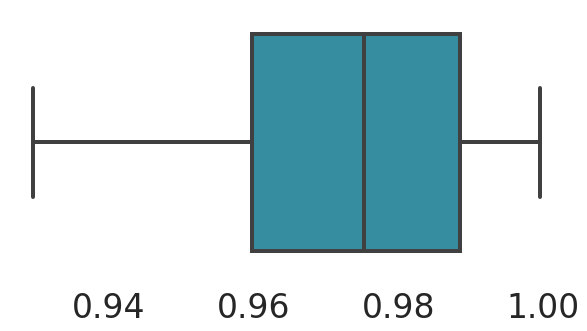

In [30]:
plt.figure(figsize=(10,5))

sns.boxplot(exp_efficiencies, orient='h', linewidth=4, color='#2598B2')
# plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
# plt.xlabel('Coding Fraction (0-1)')

# plt.show()
# plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-compare-coding-fractions.png")), bbox_inches='tight')
plt.savefig(os.path.join(GRAPHS_DIR, load_ieee_reducednet_vs_fcn_cf_file + ".png"))

In [33]:
print("Mean", np.mean(exp_efficiencies), "std-dev: ", np.std(exp_efficiencies))

Mean 0.9731374598182354 std-dev:  0.018672595083439755


In [74]:
NUM_COMP_TRIALS = 20

fcl_rednet_l1_comp_efficiencies = np.empty((NUM_COMP_TRIALS))
fcl_rednet_l2_comp_efficiencies = np.empty((NUM_COMP_TRIALS))

start_time = time.time()

# comp_fcl_l1_spikes = fcl_experiment.spike_graph()
# comp_rednet_l1_spikes = experiment.spike_graph()

for i in range(2, NUM_COMP_TRIALS):
    comp_fcl_l1_spikes = np.zeros((fcl_experiment.num_t, fcl.NUM_NEURONS))
    comp_fcl_l1_spikes[fcl_experiment.spike_times[i].astype(int), fcl_experiment.spike_neurons[i].astype(int)] = 1.0
    
    comp_rednet_l1_spikes = np.zeros((experiment.num_t, layer.NUM_NEURONS))
    comp_rednet_l1_spikes[experiment.spike_times[i].astype(int), experiment.spike_neurons[i].astype(int)] = 1.0

    comp_fcl_in_fr = fcl.firing_rate(comp_fcl_l1_spikes, dt, test_t_stop)
    comp_rednet_in_fr = layer.firing_rate(comp_rednet_l1_spikes, dt, test_t_stop)
    
    fcl_rednet_l1_comp_efficiencies[i] = 1.0 - np.linalg.norm(comp_rednet_in_fr - comp_fcl_in_fr)/np.linalg.norm(comp_fcl_in_fr)
    
    _, comp_fcl_out_spikes = fcl.spike(fcl_experiment.outputs[:, i], dt, test_t_stop)
    _, comp_rednet_out_spikes = layer.spike(experiment.outputs[:, i], dt, test_t_stop)

    comp_fcl_out_fr = fcl.firing_rate(comp_fcl_out_spikes, dt, test_t_stop)
    comp_rednet_out_fr = layer.firing_rate(comp_rednet_out_spikes, dt, test_t_stop)
    
    fcl_rednet_l2_comp_efficiencies[i] = 1.0 - np.linalg.norm(comp_rednet_out_fr - comp_fcl_out_fr)/np.linalg.norm(comp_fcl_out_fr)
    
    print("Trial", i, ": ", time.time() - start_time)

(200, 1)
(200,)


ValueError: setting an array element with a sequence.

In [ ]:
comp_fcl_l1_spikes = np.zeros((fcl_experiment.num_t, fcl.NUM_NEURONS))
comp_fcl_l1_spikes[fcl_experiment.spike_times[i].astype(int), fcl_experiment.spike_neurons[i].astype(int)] = 1.0

graph_psth(F_binary, 10000, title=None, xlabel=None, ylabel=None, save=(os.path.join(GRAPHS_DIR, "ieee-rev-verif_rednet_input_spikes.png")))

In [83]:
compare_efficiencies = pd.DataFrame({'FCN-Grad': fcl_efficiencies, 'ReducedNet': efficiencies})

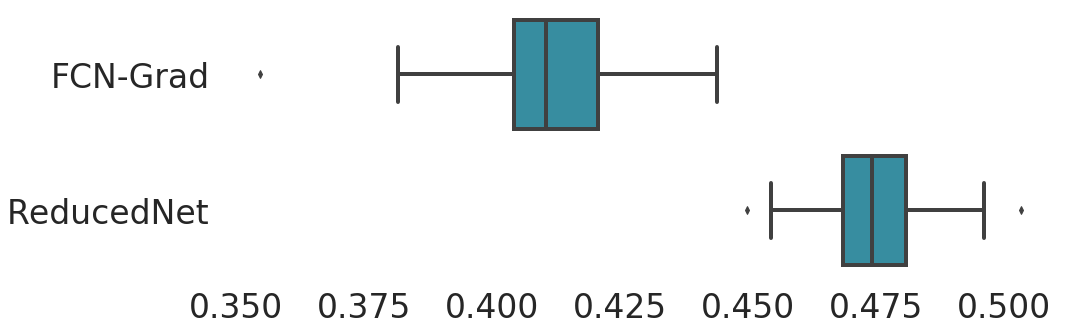

In [84]:
plt.figure(figsize=(15,5))

sns.boxplot(data=compare_efficiencies, orient='h', linewidth=4, color='#2598B2')
# plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
# plt.xlabel('Coding Fraction (0-1)')

# plt.show()
plt.savefig((os.path.join(GRAPHS_DIR, "ieee-rev-compare-coding-fractions.png")), bbox_inches='tight')